# M7_AI2_Frameworks
#### Autor: Leandro Gutierrez
#### Este documento intenta dar respuesta a la actividad 2 propuesta en el Modulo **Técnicas Avanzadas de Machine Learning**. En él se describirán cada uno de los enunciados postulados y los resultados obtenidos.
#### Diciembre 15, 2024

# Enunciado
## Contexto
En la actualidad, disponemos de framework de Deep Learning, como Tensorflow o Pytorch, que facilitan mucho el desarrollo de Redes Neuronales porque ofrecen: 

- Componentes básicos para desarrollar nuestros propios modelos. 
- Distintos modelos de Deep Learning pre-entrenados.
- Datasets para entrenar esos modelos.

En esta actividad adquiriremos un conocimiento básico de ambos framework mediante un ejercicio práctico que consiste en: 
- Cargar el dataset de imágenes CIFAR10 (del Canadian Institute for Advanced Research), disponible en ambos framework. Este dataset presenta las siguientes características: 
  - Consta de 50.000 imágenes de entrenamiento y 10.000 de prueba.
  - Los datasets se reparten en 10 clases: 
      'plane' (avión) 
      'car' (coche) 
      'bird' (pájaro) 
      'cat' (gato) 
      'deer' (ciervo) 
      'dog' (perro) 
      'frog' (rana) 
      'horse' (caballo) 
      'ship' (barco) 
      'truck' (camión)
  - Las imágenes tienen una dimensión de 32 x 32 pixels, y son en color (3 canales). 
- Crear una Red Neuronal simple (feedforward) con el modo Sequential de ambos framework, compuesta por:
    - Una capa para pasar las imágenes de 2D a 1D (si es necesario).
    - Dos capas lineales con 128 y 64 nodos, seguidas cada una de una función de activación ReLU.
    - Una capa de salida softmax que obtenga la probabilidad de cada clase.
- Entrenar ambas Redes con las opciones siguientes: 
    - Optimizador: Stochastic Gradient Descent.
    - Función de pérdida (loss): cross entropy, teniendo en cuenta que nuestra salida es categórica.
    - Tamaño de lote (batch size): 16 imágenes o Entrenar durante 100 iteraciones (epochs) o Proporción entre entrenamiento y validación: 80% - 20%.
- Evaluación de ambos modelos: 
    - Grafica las curvas de loss para datos de entrenamiento y validación en función de la iteración. 
    - Se requiere mostrar el accuracy final del modelo una vez se evalúa con la partición de test. Del mismo modo, mostrar el accuracy en la partición de validación.
- Consideraciones: 
    - Framework a utilizar: Tensorflow y Pytorch.
    - Conviene revisar que las dimensiones de la Red son correctas antes de comenzar a entrenar.
    - Al entrenar con tensorflow, utilizar los métodos compile y fit heredados.

# Solución

In [335]:
# importamos las librerias
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers, datasets
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

Utilizaremos una variable auxilar global para definir los `epochs` de ambos modelos

In [336]:
epochs = 50

Utilizaremos solo 50 iteraciones de entrenamiento para nuestras redes neuronales debido al alto coste computacional vinculado, expresado esto en tiempo de procesamiento, lo que genera en algunas ocaciones la imposibilidad de reentrenar nuestros modelos y poder probar diferentes configuraciones. Consideraremos que los resultados obtenidos con esta cantidad de `epochs` serán suficientes para el ámbito academico donde se presentará este trabajo práctico y se entiende que de incrementarse este valor los desempeños de los modelos crecerán moderadamente.

## Clasificación de imágenes CIFAR10 con Tensorflow

### Carga de datos

Comenzamos descargando los datos mediante `tensorflow`

In [337]:
# descargamos las imagenes
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

Veamos la forma de nuestras particiones de entrenamiento y testeo

In [338]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Vemos que contamos con **50000** observaciones en nuestra partición de `entrenamiento` y **10000** en la de `testeo`. Además sabemos por la documentación de [Tensorflow](https://www.tensorflow.org/datasets/catalog/cifar10) que contamos con **6000** imagenes por clase.

A su vez notamos que cada muestra (imagen) es, en sí misma, un array de 3 dimensiones de tamaño 32x32x3, esto indica que cada imagen tiene 32x32 pixeles, mientras que la tercera dimensión indica el canal de color: rojo, verde o azul (RGB), cada celda lleva un valor entero entre 0 y 255, y representa el color de cada pixel en escala RGB.

Veamos algunas de las imagenes que analizaremos

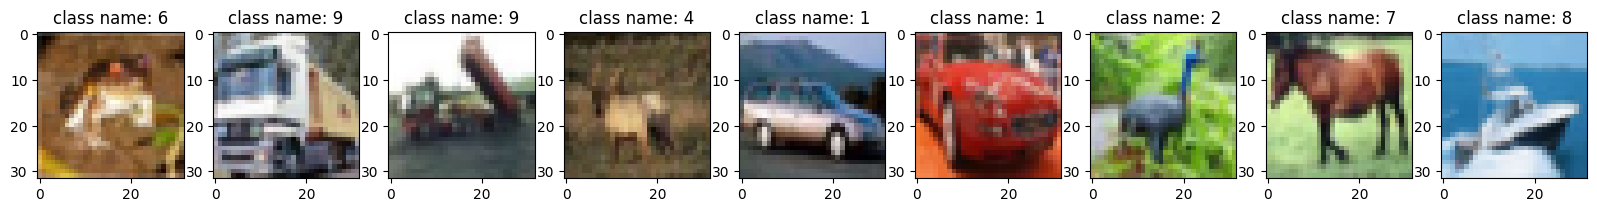

In [339]:
# class_names = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# graficamos las imagenes
_, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 8))
for ax, image, label in zip(axes, x_train, y_train):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("class name: %s" % class_names[label[0]])

### Creación del modelo

In [341]:
# definimos var auxiliar
input_size = (32, 32, 3)

# definimos el modelo
model_tf = models.Sequential()

model_tf.add(layers.Flatten(input_shape=input_size))
model_tf.add(layers.Dense(128, activation='relu'))
model_tf.add(layers.Dense(64, activation='relu'))
model_tf.add(layers.Dense(10, activation="softmax")) # el número de nodos entrantes es el de salientes de Flatten

model_tf.summary()

/Users/lgutierrez/Proyectos/master-compartido/TFM/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,250 (1.53 MB)

 Trainable params: 402,250 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [342]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, nesterov=True)

model_tf.compile(
    optimizer=sgd_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Entrenamiento

In [340]:
# normalizamos los datos de entrenamiento
x_train = x_train / 255.0

# convertimos en categóricas las etiquetas de las imagenes
y_train_c = to_categorical(y_train)

In [343]:
# entrenamos el modelo
history = model_tf.fit(
    x_train, y_train_c,
    epochs=epochs,
    batch_size=16,
    validation_split=0.2
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2633 - loss: 2.0113 - val_accuracy: 0.3755 - val_loss: 1.7584
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3830 - loss: 1.7198 - val_accuracy: 0.4054 - val_loss: 1.6714
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - accuracy: 0.4195 - loss: 1.6323 - val_accuracy: 0.4165 - val_loss: 1.6489
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4383 - loss: 1.5785 - val_accuracy: 0.4248 - val_loss: 1.6098
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4517 - loss: 1.5358 - val_accuracy: 0.4355 - val_loss: 1.5869
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step - accuracy: 0.4663 - loss: 1.4949 - val_accuracy: 0.4350 - val_loss: 1.5981
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - accuracy: 0.4823 - loss: 1.4640 - val_accuracy: 0.4614 - val_loss: 1.5329
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4873 - loss: 1.4

Durante las iteraciones de entrenamiento se perciben mejoras progresivas tanto en la particion de entrenamiento como en la de validación, mejorando significativamente las métricas `accuracy` (creciente) y `loss` (decreciente). Finalizando con valores de `accuracy` en entrenamiento de **0.65** y en validación de **0.50**.

### Evaluación

In [344]:
# realizamos las predicciones sobre el set de evaluación
y_pred = model_tf.predict(x_test)

# tomamos la clase de mayor probabilidad
y_test_c = to_categorical(y_test)

# visualizamos las metricas del modelo en evaluación
test_loss, test_metric = model_tf.evaluate(x_test, y_test_c)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.4353 - loss: 344.2112


Obtuvimos un valor de `accuracy` de **0.43** durante la etapa de evaluación para nuestro modelo `Tensorflow` y un valor para la función de perdida de **344.21**.

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.43      0.70      0.53      1000
           1       0.51      0.69      0.59      1000
           2       0.58      0.17      0.26      1000
           3       0.32      0.15      0.20      1000
           4       0.69      0.08      0.14      1000
           5       0.28      0.63      0.39      1000
           6       0.80      0.19      0.31      1000
           7       0.47      0.52      0.50      1000
           8       0.56      0.66      0.60      1000
           9       0.43      0.58      0.49      1000

    accuracy                           0.44     10000
   macro avg       0.51      0.44      0.40     10000
weighted avg       0.51      0.44      0.40     10000

Matriz de confusión:


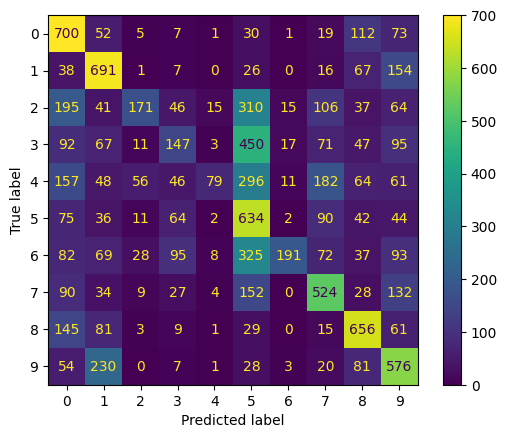

In [345]:
# convertimos las predicciones de probabilidades
y_pred_classes = np.argmax(y_pred, axis=1)

# tomamos la clase de mayor probabilidad
y_test_classes = np.argmax(y_test_c, axis=1)

# visualizamos classifcation report
print("Reporte de clasificación:")
print(classification_report(y_test_classes, y_pred_classes))

# calculamos la matriz de confusión
print("Matriz de confusión:")
cm = confusion_matrix(y_test_classes, y_pred_classes)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Podemos apreciar que tenemos nuestro modelo posee una `accuracy` general de **0.44**, lo que nos indica que nuestro modelo clasifica de manera correcta el **44%** de las instancias analizadas.Tambien podemos ver que en promedio la `precision` es de **0.51** y el `recall` de **0.44**.

De la matriz de confusión observamos que existen algunas clases con mejor desempeño que otras, notamos por ejemplo que la clase `plane` (Nro 0) es la de mejor balance entre precision y recall siendo correctamente clasificada en **700** oportunidades de un total de **1000** exponentes de la clase. Mientras que la clase `deer` (Nro 4) es la de peor performance general, siendo clasificada correctamente solo en el **7.9%** de las veces. De la experimentación con diferentes epochs se percibió constantes problemas con la clase 4, llegando en ocaciones a no predecir ninguna imagen con dicha etiqueta. Tambín notamos como tiende a preferir sobreclasificar la clase 5, expresandose esto en un buen valor de `recall` pero una `precisión` pobre.

## Clasificación de imágenes CIFAR10 con Pytorch

In [346]:
# cargamos las librerias que utilizaremos
import torch
from torch import nn
from torch.optim import SGD
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Carga de datos

In [347]:
# normalizamos los datos [0,1] para emular lo hecho con Tensorflow
transform = transforms.Compose([transforms.ToTensor()])

# obtenemos el trainset con el parámetro train=True
trainset = datasets.CIFAR10('~/.pytorch/cifar10/', download=True, train=True, transform=transform)

# dividimos en entrenamiento y validación
train_size = int(0.8 * len(trainset))  # 80% para entrenamiento
val_size = len(trainset) - train_size  # 20% para validación
trainset, validationset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
validationloader = DataLoader(validationset, batch_size=16, shuffle=False)

# obtenemos el testset con el parámetro train=False
testset = datasets.CIFAR10('~/.pytorch/cifar10/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Creación del modelo

In [348]:
model_pt = nn.Sequential(nn.Flatten(),
                    nn.Linear(3072, 128),
                    nn.ReLU(),          # Función de activación ReLU
                    nn.Linear(128, 64),
                    nn.ReLU(),          # Función de activación ReLU
                    nn.Linear(64, 10),
                    nn.Softmax(dim=1))

print(model_pt)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): Softmax(dim=1)
)


In [349]:
optimizer = SGD(model_pt.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

### Entrenamiento

In [350]:
model_pt.train()

def accuracy (outputs, target):
    preds = torch.argmax(outputs, dim=1)
    return torch.mean((preds == target).float())

for epoch in range(epochs):
    running_loss_train = 0.0
    running_accuracy_train = 0.0

    for x_train, y_train in trainloader:
        # inicializa los gradientes de los parámetros
        optimizer.zero_grad()
        # calcula hacia adelante
        outputs = model_pt(x_train) # ejecuta el método forward
        # calcula la pérdida
        loss = criterion(outputs, y_train)
        # calcula los gradientes a partir de la pérdida
        loss.backward()
        # actualiza los pesos del modelo aplicando los gradientes a los parámetros
        optimizer.step()
                
        # Acumulamos el loss y accuracy para el entrenamiento
        running_loss_train += loss.item()
        running_accuracy_train += accuracy(outputs, y_train).item()

    # Promedio de loss y accuracy para el entrenamiento
    avg_loss_train = running_loss_train / len(trainloader)
    avg_accuracy_train = running_accuracy_train / len(trainloader)
    
    preds, targets = [], []
    running_loss_val = 0.0

    for x_val, y_val in validationloader:
        outputs = model_pt(x_val)
        loss_val = criterion(outputs, y_val)
        
        running_loss_val += loss_val.item()
        preds.append(outputs)
        targets.append(y_val)

    preds = torch.vstack(preds)
    targets = torch.hstack(targets)
    
    avg_loss_val = running_loss_val / len(validationloader)
    avg_accuracy_val = accuracy(preds, targets).item()

    print(f"Epoch {epoch+1}/{epochs}, "
          f"accuracy: {avg_accuracy_train:.4f}, loss: {avg_loss_train:.4f}, "
          f"accuracy_val: {avg_accuracy_val:.4f}, loss_val: {avg_loss_val:.4f}")

Epoch 1/50, accuracy: 0.1167, loss: 2.2967, accuracy_val: 0.1034, loss_val: 2.2861
Epoch 2/50, accuracy: 0.1928, loss: 2.2500, accuracy_val: 0.2616, loss_val: 2.2123
Epoch 3/50, accuracy: 0.2689, loss: 2.1911, accuracy_val: 0.2836, loss_val: 2.1751
Epoch 4/50, accuracy: 0.2849, loss: 2.1715, accuracy_val: 0.2848, loss_val: 2.1632
Epoch 5/50, accuracy: 0.2945, loss: 2.1601, accuracy_val: 0.3030, loss_val: 2.1547
Epoch 6/50, accuracy: 0.3054, loss: 2.1504, accuracy_val: 0.3153, loss_val: 2.1413
Epoch 7/50, accuracy: 0.3161, loss: 2.1408, accuracy_val: 0.3268, loss_val: 2.1328
Epoch 8/50, accuracy: 0.3263, loss: 2.1311, accuracy_val: 0.3278, loss_val: 2.1257
Epoch 9/50, accuracy: 0.3336, loss: 2.1233, accuracy_val: 0.3333, loss_val: 2.1201
Epoch 10/50, accuracy: 0.3414, loss: 2.1157, accuracy_val: 0.3505, loss_val: 2.1058
Epoch 11/50, accuracy: 0.3570, loss: 2.1036, accuracy_val: 0.3662, loss_val: 2.0936
Epoch 12/50, accuracy: 0.3651, loss: 2.0932, accuracy_val: 0.3750, loss_val: 2.0852
E

Al igual que en el modelo implementado con `Tensorflow`, en el caso de `Pytorch` se aprecia una mejora progresiva entre las iteraciones de entrenamiento, tanto en la particion de entrenamiento como en la de validación.

De este segundo modelo podemos decir que tiene performance levemente inferior al anterior durante entrenamiento, con una `accuracy` de entrenamiento de **0.51** y en validación de **0.46**, ambos menores a los obtenidos durane el entrenamiento del modelo desarrollado con `Tensorflow`.

### Evaluación

Procederemos a evaluar nuestro modelo con la partición de `testo` la cual no fué vista anteriormente por el modelo

In [353]:
# preparamos el modelo para evaluacion
model_pt.eval()

# deshabilitamos el cálculo de gradientes en inferencia
with torch.no_grad():
    preds, targets = [], []
    for x_val, y_val in testloader:
        preds.append(model_pt(x_val))
        targets.append(y_val)

preds = torch.vstack(preds)
targets = torch.hstack(targets)

print(f"Accuracy sobre dataset de prueba: {accuracy(preds, targets):.4f}")

Accuracy sobre dataset de prueba: 0.4713


Obtuvimos un `accuracy` de **0.47** durante la etapa de evaluación para nuestro modelo `Pytorch`, valor ligeramente mejor que el que obtuvimos para la etapa de testeo del modelo `Tensorflow`.

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.55      0.49      0.52      1000
           1       0.57      0.59      0.58      1000
           2       0.34      0.30      0.32      1000
           3       0.37      0.26      0.30      1000
           4       0.40      0.42      0.41      1000
           5       0.38      0.40      0.39      1000
           6       0.49      0.54      0.51      1000
           7       0.51      0.53      0.52      1000
           8       0.56      0.66      0.60      1000
           9       0.50      0.53      0.51      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000

Matriz de confusión:


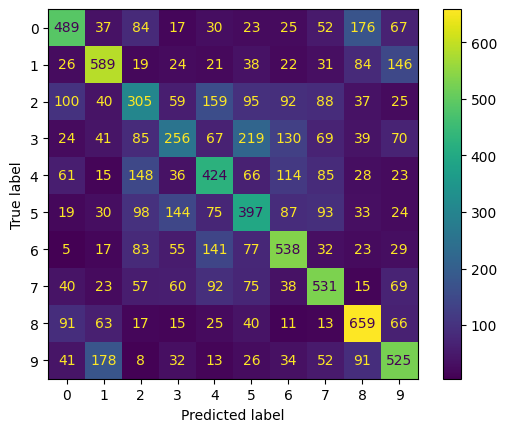

In [352]:
pred_classes = torch.argmax(preds, dim=1)

print("Reporte de clasificación:")
print(classification_report(targets.numpy(), pred_classes.numpy()))

print("Matriz de confusión:")
cm = confusion_matrix(targets.numpy(), pred_classes.numpy())
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


Del análisis del `reporte de clasificación` podemos ver que nuestro modelo torch posee una `accuracy` general de **0.47**, lo que nos indica que nuestro modelo clasifica de manera correcta el **47%** de las instancias analizadas.Tambien podemos ver que en promedio la `precision` es de **0.47** y el `recall` de **0.47**.

De la matriz de confusión, al igual que en el modelo implementado con `Tensorflow`, se perciben mejores resultados para las clases de los extremos (8, 9, 1) mientras que las clases del centro presentan mayores dificultades en su correcta catalogación (3, 4, 2). Sin embargo para el caso de `Pytorch` notamos un desempeño mucho más homogeneo en comparación con el primer modelo, donde algunas clases presentaban performances demasiado pobres.

## Conclusiones

Durante el desarrollo del trabajo hemos desarrollado e implemtado dos modelos de redes neuronales simples utilizando `Tensorflow` y `Pytorch`, con el objetivo de clasificar imagenes del dataset `CIFAR-10`. Ambos modelos aunque se intentó tengan arquitecturas similares presentan ligeras diferencias en su performance.

Si bien el modelo implementado con `Tensorflow` mostró un mejor desempeño durante el entrenamiento, con una performance de **0.65** para la partición de entrenamiento y de **0.50** para la de validación, en comparación con los **0.51** y **0.46** respectivos del modelo en `Pytorch`, durante la etapa de evaluación el primero obtuvo métricas levemente peores, mostrando una `accuracy` general de **0.44** vs los **0.47** del modelo `Pytorch`.

Ambos modelos mostraron problemas en algunas clases, sobre todo las centrales, como ser la 4 (`deer`) y la 3 (`cat`), lo que sugiere que éstas podría poseer características menos diferenciables, notar que todas ellas represetan `animales`. También notamos mejor desempeño en las clases de los extremos, como ser la 8 (`ship`), 1 (`car`) y la 0 (`plane`), los que casualmente representan `medios de transporte`.

En conclusión, ambos modelos mostraro resultados razonables considerando su simplicidad y la complejidad del dataset a analizar.